**1. Loading the Dataset**

In [20]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 1: Loading the raw dataset
df_raw = pd.read_csv("mental-heath-in-tech-2016_20161114.csv")
print("Loaded raw dataset. Shape:", df_raw.shape)
print("Listing columns:\n", df_raw.columns.tolist())


Loaded raw dataset. Shape: (1433, 63)
Listing columns:
 ['Are you self-employed?', 'How many employees does your company or organization have?', 'Is your employer primarily a tech company/organization?', 'Is your primary role within your company related to tech/IT?', 'Does your employer provide mental health benefits as part of healthcare coverage?', 'Do you know the options for mental health care available under your employer-provided coverage?', 'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?', 'Does your employer offer resources to learn more about mental health concerns and options for seeking help?', 'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?', 'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:', 'Do you think that discussing a mental hea

**2. Data Preprocessing**

In [23]:
# Step 2: Selecting and renaming required columns
# Mapping raw columns to cleaned names
rename_columns = {
    'Have you ever sought treatment for a mental health issue from a mental health professional?': 'treatment',
    'What is your age?': 'age',
    'What is your gender?': 'gender',
    'Do you have a family history of mental illness?': 'family_history',
    'Does your employer provide mental health benefits as part of healthcare coverage?': 'mental_health_benefits',
    'Do you know the options for mental health care available under your employer-provided coverage?': 'care_options',
    'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?': 'employer_discussed',
    'Does your employer offer resources to learn more about mental health concerns and options for seeking help?': 'resources_provided',
    'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?': 'anonymity_protected',
    'What country do you live in?': 'country',
    'What country do you work in?': 'work_country',
    'Do you work remotely?': 'remote_work',
    'Are you self-employed?': 'self_employed',
    'How many employees does your company or organization have?': 'company_size',
    'Is your employer primarily a tech company/organization?': 'tech_company',
    'Is your primary role within your company related to tech/IT?': 'tech_role',
    'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:': 'leave_difficulty',
    'Would you feel comfortable discussing a mental health disorder with your coworkers?': 'coworker_comfort',
    'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?': 'supervisor_comfort',
    'Do you feel that your employer takes mental health as seriously as physical health?': 'equal_mental_physical'
}

# Keeping only selected columns and renaming them
df = df_raw[list(rename_columns.keys())].rename(columns=rename_columns)
print("Selected and renamed columns. Shape:", df.shape)

# Step 3: Checking missing values before processing
print("Counting missing values before preprocessing:\n", df.isnull().sum())


Selected and renamed columns. Shape: (1433, 20)
Counting missing values before preprocessing:
 treatment                    0
age                          0
gender                       3
family_history               0
mental_health_benefits     287
care_options               420
employer_discussed         287
resources_provided         287
anonymity_protected        287
country                      0
work_country                 0
remote_work                  0
self_employed                0
company_size               287
tech_company               287
tech_role                 1170
leave_difficulty           287
coworker_comfort           287
supervisor_comfort         287
equal_mental_physical      287
dtype: int64


**3. Final Dataset Preparation**

In [26]:
# Filling missing values for numeric and categorical columns
# Filling numeric missing values using median
num_cols = ['age']
df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))

# Filling categorical missing values using mode
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Cleaning gender column
def clean_gender(val):
    val = str(val).lower()
    if val in ['male', 'm', 'man']:
        return 'Male'
    elif val in ['female', 'f', 'woman']:
        return 'Female'
    else:
        return 'Other'
df['gender'] = df['gender'].apply(clean_gender)

# Encoding binary yes/no type columns robustly
binary_map = {'yes': 1, 'no': 0}
binary_cols = ['family_history', 'mental_health_benefits', 'care_options',
               'employer_discussed', 'resources_provided', 'anonymity_protected',
               'self_employed', 'tech_company', 'tech_role',
               'coworker_comfort', 'supervisor_comfort', 'equal_mental_physical']
for col in binary_cols:
    df[col] = df[col].astype(str).str.lower().map(binary_map).fillna(0)

print("Previewing cleaned dataset:\n", df.head())
print("Checking missing values after cleaning:\n", df.isnull().sum())


Previewing cleaned dataset:
    treatment  age  gender  family_history  mental_health_benefits  \
0          0   39    Male             0.0                     0.0   
1          1   29    Male             1.0                     0.0   
2          1   38   Other             0.0                     0.0   
3          1   43    Male             0.0                     1.0   
4          1   43  Female             1.0                     1.0   

   care_options  employer_discussed  resources_provided  anonymity_protected  \
0           0.0                 0.0                 0.0                  0.0   
1           1.0                 1.0                 1.0                  1.0   
2           0.0                 0.0                 0.0                  0.0   
3           0.0                 0.0                 0.0                  0.0   
4           1.0                 0.0                 0.0                  0.0   

                    country              work_country remote_work  \
0     

**4. EDA (Exploratory Data Analysis)**

Previewing age groups:
    age age_group
0   39     35-44
1   29     25-34
2   38     35-44
3   43     35-44
4   43     35-44


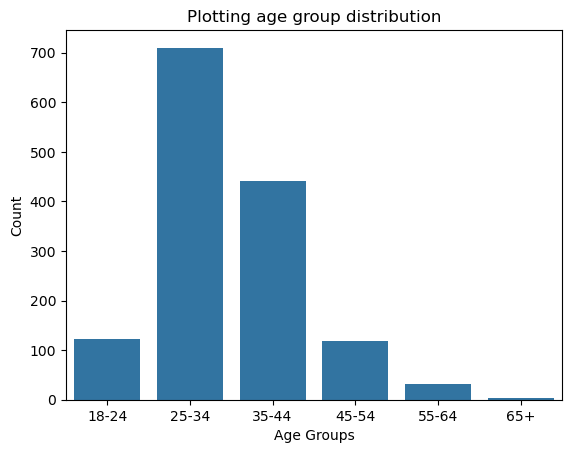

In [33]:
# Filtering out unrealistic ages (e.g., > 80 or < 18)
df = df[(df['age'] >= 18) & (df['age'] <= 80)]

# Creating age bins
age_bins = [18, 24, 34, 44, 54, 64, 80]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=True)

print("Previewing age groups:\n", df[['age', 'age_group']].head())

# Plotting grouped age distribution
sns.countplot(x='age_group', data=df, order=age_labels)
plt.title("Plotting age group distribution")
plt.xlabel("Age Groups")
plt.ylabel("Count")
plt.show()




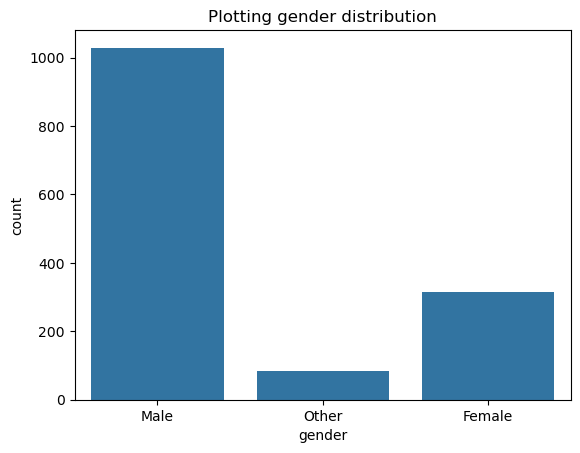

In [35]:
# Plotting gender distribution
sns.countplot(x='gender', data=df)
plt.title("Plotting gender distribution")
plt.show()

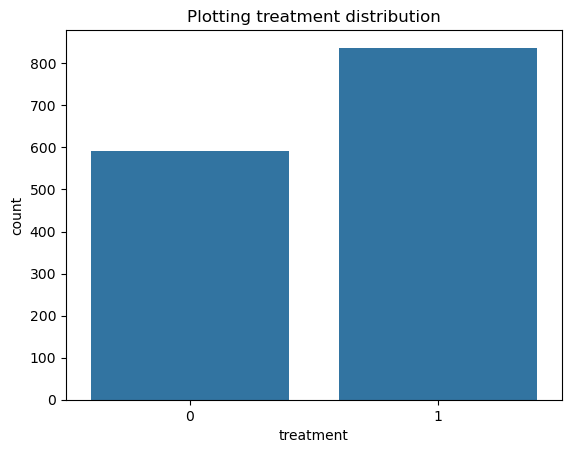

In [37]:
# Plotting treatment counts
sns.countplot(x='treatment', data=df)
plt.title("Plotting treatment distribution")
plt.show()

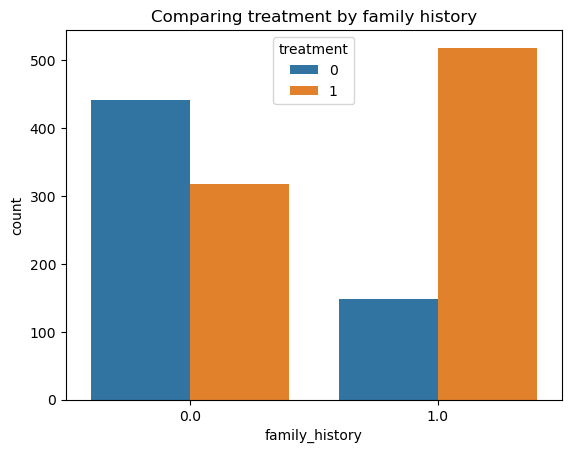

In [39]:
# Plotting treatment by family history
sns.countplot(x='family_history', hue='treatment', data=df)
plt.title("Comparing treatment by family history")
plt.show()

Top correlations with treatment:
 treatment                 1.000000
family_history            0.363210
gender                    0.196328
care_options              0.183629
mental_health_benefits    0.157631
age                       0.067526
resources_provided        0.058640
leave_difficulty          0.046663
employer_discussed        0.030127
anonymity_protected       0.023974
coworker_comfort          0.023106
remote_work               0.003269
supervisor_comfort        0.000735
company_size             -0.004341
equal_mental_physical    -0.064720
country                  -0.103700
work_country             -0.118374
self_employed                  NaN
tech_company                   NaN
tech_role                      NaN
Name: treatment, dtype: float64


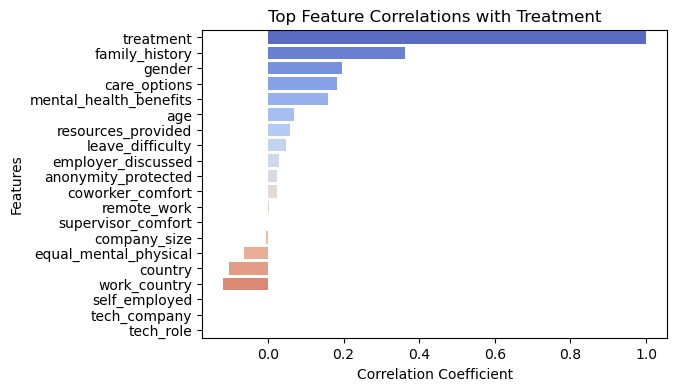

In [47]:
# Computing correlation matrix
corr_matrix = encoded_df.corr()

# Extracting correlations with 'treatment'
target_corr = corr_matrix['treatment'].sort_values(ascending=False)
print("Top correlations with treatment:\n", target_corr)

plt.figure(figsize=(6,4))
sns.barplot(x=target_corr.values, y=target_corr.index, hue=target_corr.index, palette="coolwarm", dodge=False, legend=False)
plt.title("Top Feature Correlations with Treatment")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.show()



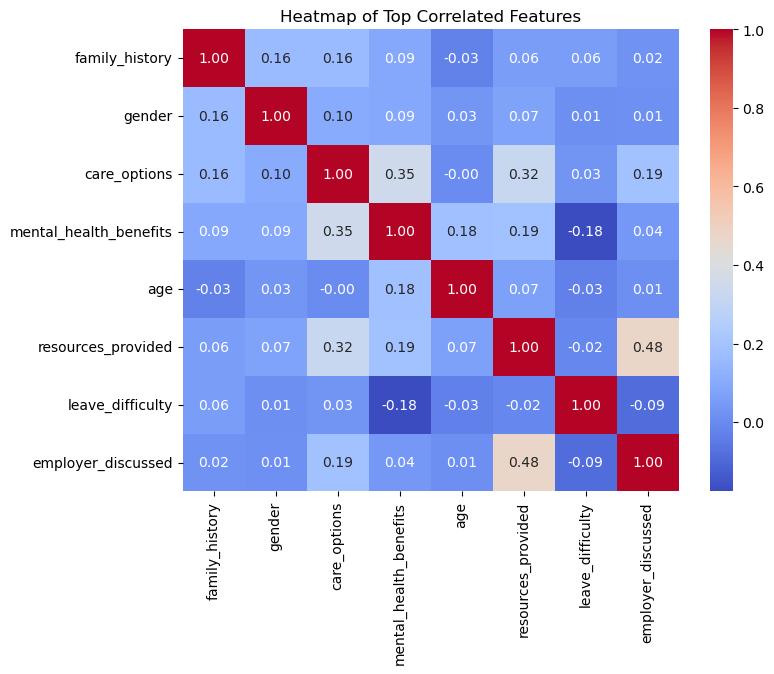

In [49]:
# Selecting top 8 features correlated with treatment
top_features = target_corr.index[1:9]  # excluding treatment itself

# Subset correlation matrix
filtered_corr = corr_matrix.loc[top_features, top_features]

plt.figure(figsize=(8,6))
sns.heatmap(filtered_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap of Top Correlated Features")
plt.show()


**5. Statistical Analysis**

In [54]:
# Performing chi-square test for family history vs treatment
chi_table = pd.crosstab(df['family_history'], df['treatment'])
chi2, p, _, _ = chi2_contingency(chi_table)
print(f"Chi-square (Family History vs Treatment): chi2={chi2:.2f}, p={p:.8f}")

# Performing t-test for age vs treatment
treated = df[df['treatment']==1]['age']
not_treated = df[df['treatment']==0]['age']
t_stat, p_val = ttest_ind(treated, not_treated)
print(f"Running T-test for age: t={t_stat:.2f}, p={p_val:.4f}")


Chi-square (Family History vs Treatment): chi2=186.91, p=0.00000000
Running T-test for age: t=2.56, p=0.0107


**6.Modeling**

In [58]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()

for col in df_model.select_dtypes(exclude=['int64', 'float64']).columns:
    df_model[col] = label_enc.fit_transform(df_model[col].astype(str))

print("All features encoded. Checking dtypes:\n", df_model.dtypes)

# Splitting into features and target
X = df_model.drop(columns=['treatment'])
y = df_model['treatment']

# Splitting dataset into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)
y_pred_log = logreg.predict(X_test_scaled)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))

# Training Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

# Printing classification reports
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_log))
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))


All features encoded. Checking dtypes:
 treatment                   int64
age                         int64
gender                      int32
family_history            float64
mental_health_benefits    float64
care_options              float64
employer_discussed        float64
resources_provided        float64
anonymity_protected       float64
country                     int32
work_country                int32
remote_work                 int32
self_employed             float64
company_size                int32
tech_company              float64
tech_role                 float64
leave_difficulty            int32
coworker_comfort          float64
supervisor_comfort        float64
equal_mental_physical     float64
age_group                   int32
dtype: object
Logistic Regression Accuracy: 0.6923076923076923
Random Forest Accuracy: 0.6398601398601399
Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.62      0.70      0.66       121
  

In [60]:

from xgboost import XGBClassifier
# 1. Training XGBoost Model
xgb = XGBClassifier(
    random_state=42,
    eval_metric='logloss',      
    use_label_encoder=False,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# 2. Evaluating XGBoost
print("\nXGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix (XGBoost):\n", confusion_matrix(y_test, y_pred_xgb))




C:\Users\rocki\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:21:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Accuracy: 0.6433566433566433
XGBoost Report:
               precision    recall  f1-score   support

           0       0.59      0.54      0.56       121
           1       0.68      0.72      0.70       165

    accuracy                           0.64       286
   macro avg       0.63      0.63      0.63       286
weighted avg       0.64      0.64      0.64       286

Confusion Matrix (XGBoost):
 [[ 65  56]
 [ 46 119]]


In [62]:
from sklearn.svm import SVC


# 1. Training Linear SVM
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train_scaled, y_train)
y_pred_svm_linear = svm_linear.predict(X_test_scaled)

print("\nSVM (Linear) Accuracy:", accuracy_score(y_test, y_pred_svm_linear))
print("SVM (Linear) Report:\n", classification_report(y_test, y_pred_svm_linear))
print("Confusion Matrix (SVM Linear):\n", confusion_matrix(y_test, y_pred_svm_linear))


# 2. Training RBF Kernel SVM
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train_scaled, y_train)
y_pred_svm_rbf = svm_rbf.predict(X_test_scaled)

print("\nSVM (RBF Kernel) Accuracy:", accuracy_score(y_test, y_pred_svm_rbf))
print("SVM (RBF) Report:\n", classification_report(y_test, y_pred_svm_rbf))
print("Confusion Matrix (SVM RBF):\n", confusion_matrix(y_test, y_pred_svm_rbf))



SVM (Linear) Accuracy: 0.6713286713286714
SVM (Linear) Report:
               precision    recall  f1-score   support

           0       0.58      0.79      0.67       121
           1       0.79      0.59      0.67       165

    accuracy                           0.67       286
   macro avg       0.69      0.69      0.67       286
weighted avg       0.70      0.67      0.67       286

Confusion Matrix (SVM Linear):
 [[95 26]
 [68 97]]

SVM (RBF Kernel) Accuracy: 0.6818181818181818
SVM (RBF) Report:
               precision    recall  f1-score   support

           0       0.62      0.64      0.63       121
           1       0.73      0.72      0.72       165

    accuracy                           0.68       286
   macro avg       0.67      0.68      0.68       286
weighted avg       0.68      0.68      0.68       286

Confusion Matrix (SVM RBF):
 [[ 77  44]
 [ 47 118]]


**7. Subgroup analysis**


Treatment Seeking by 'gender':
treatment     0     1
gender               
Female     0.26  0.74
Male       0.48  0.52
Other      0.23  0.77


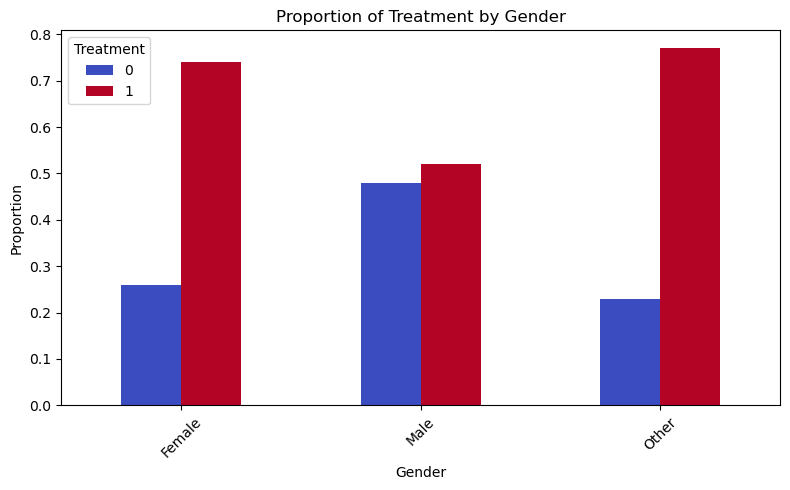


Treatment Seeking by 'remote_work':
treatment       0     1
remote_work            
Always       0.40  0.60
Never        0.44  0.56
Sometimes    0.41  0.59


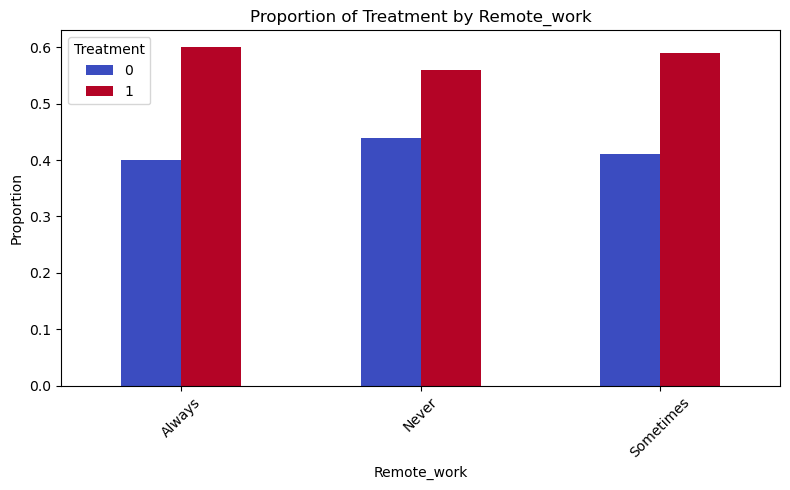


Treatment Seeking by 'mental_health_benefits':
treatment                  0     1
mental_health_benefits            
0.0                     0.50  0.50
1.0                     0.35  0.65


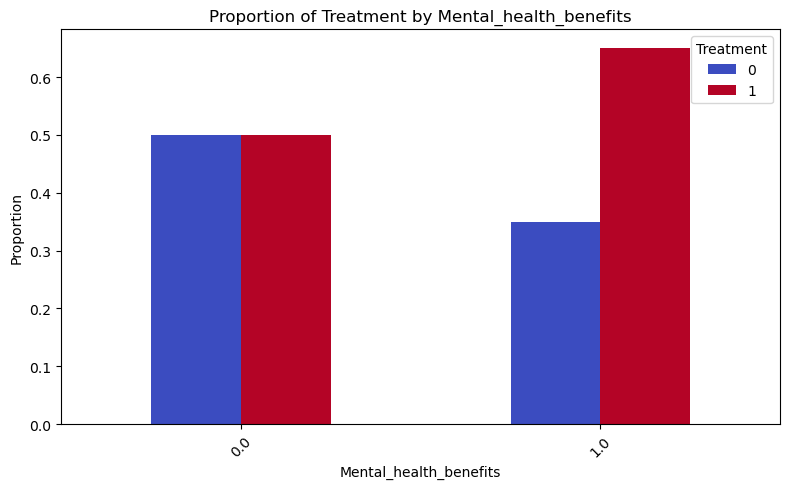

In [66]:
# Copying the cleaned dataset
df_groups = df.copy()

def subgroup_analysis(feature, target='treatment'):
    """Calculating and displaying normalized proportions of treatment-seeking within each subgroup."""
    print(f"\nTreatment Seeking by '{feature}':")
    summary = df_groups.groupby(feature)[target].value_counts(normalize=True).unstack().round(2)
    print(summary)

def plot_subgroup_proportions(feature, target='treatment'):
    """Plotting treatment-seeking proportions by subgroup."""
    prop_df = df_groups.groupby(feature)[target].value_counts(normalize=True).unstack().round(2)
    prop_df.plot(kind='bar', figsize=(8, 5), colormap='coolwarm')
    plt.title(f"Proportion of Treatment by {feature.capitalize()}")
    plt.ylabel("Proportion")
    plt.xlabel(feature.capitalize())
    plt.legend(title='Treatment')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Running subgroup analysis for key variables
subgroup_analysis("gender")
plot_subgroup_proportions("gender")

subgroup_analysis("remote_work")
plot_subgroup_proportions("remote_work")

subgroup_analysis("mental_health_benefits")
plot_subgroup_proportions("mental_health_benefits")


**SHAP Analysis**

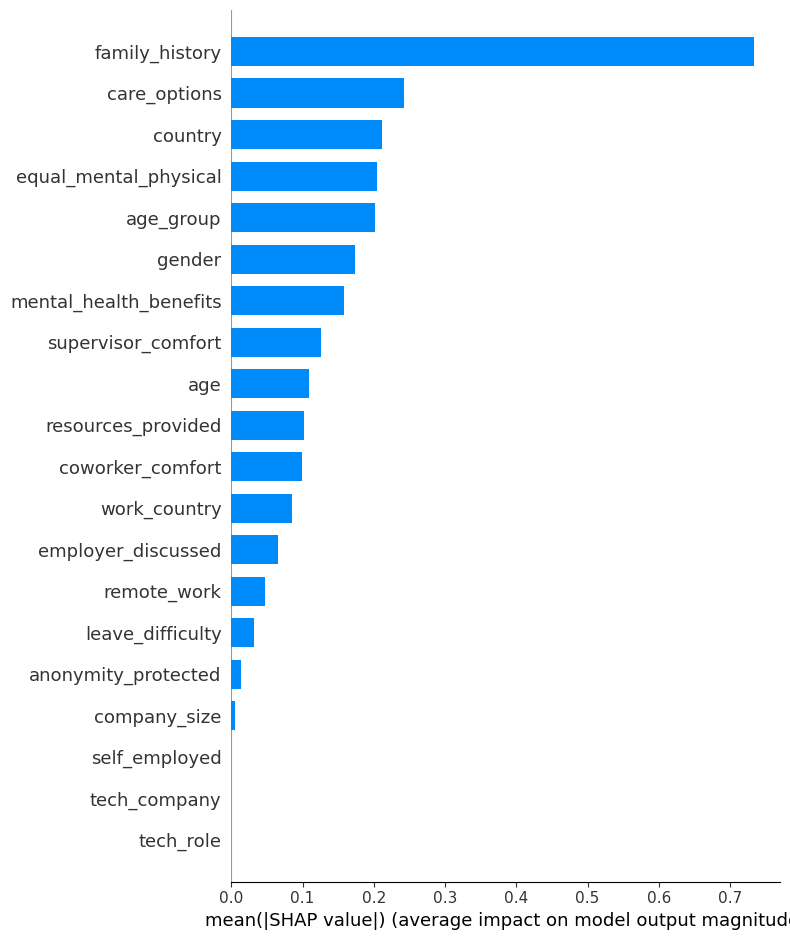

In [75]:
import shap

# Using the trained Logistic Regression model for SHAP (interpretable)
explainer = shap.Explainer(logreg, X_train_scaled)
shap_values = explainer(X_test_scaled)
shap.summary_plot(shap_values, features=X_test, feature_names=X.columns, plot_type="bar")




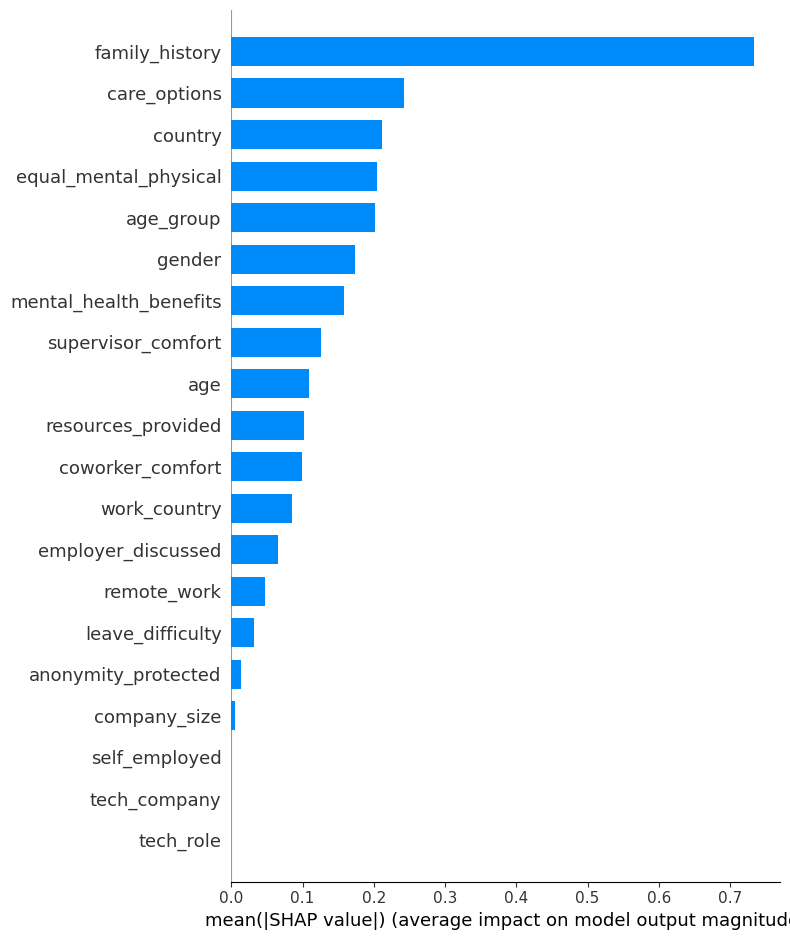

In [81]:
# Plotting global feature importance
# Correct SHAP summary plot with proper feature names
shap.summary_plot(
    shap_values,
    features=X_test, 
    feature_names=X.columns, 
    plot_type="bar"
)


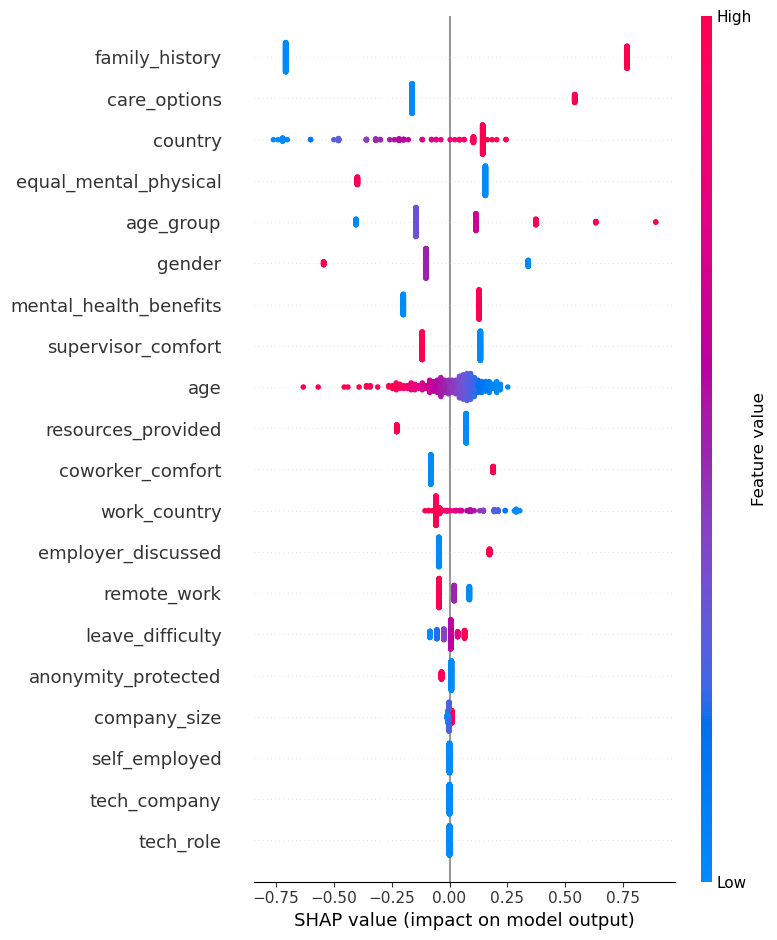

In [83]:
shap.summary_plot(
    shap_values,
    features=X_test,
    feature_names=X.columns
)

**Coefficient Analysis for Logistic Regression**

Top 10 Positive Coefficients (Strong predictors of seeking treatment):

family_history            0.736775
care_options              0.288958
country                   0.269977
age_group                 0.219793
mental_health_benefits    0.162325
coworker_comfort          0.107359
employer_discussed        0.080417
leave_difficulty          0.044751
company_size              0.005945
self_employed             0.000000
dtype: float64 

Top 10 Negative Coefficients (Strong predictors of NOT seeking treatment):

equal_mental_physical   -0.241048
gender                  -0.224062
age                     -0.127021
supervisor_comfort      -0.125872
resources_provided      -0.122028
work_country            -0.108571
remote_work             -0.054448
anonymity_protected     -0.017910
self_employed            0.000000
tech_company             0.000000
dtype: float64 



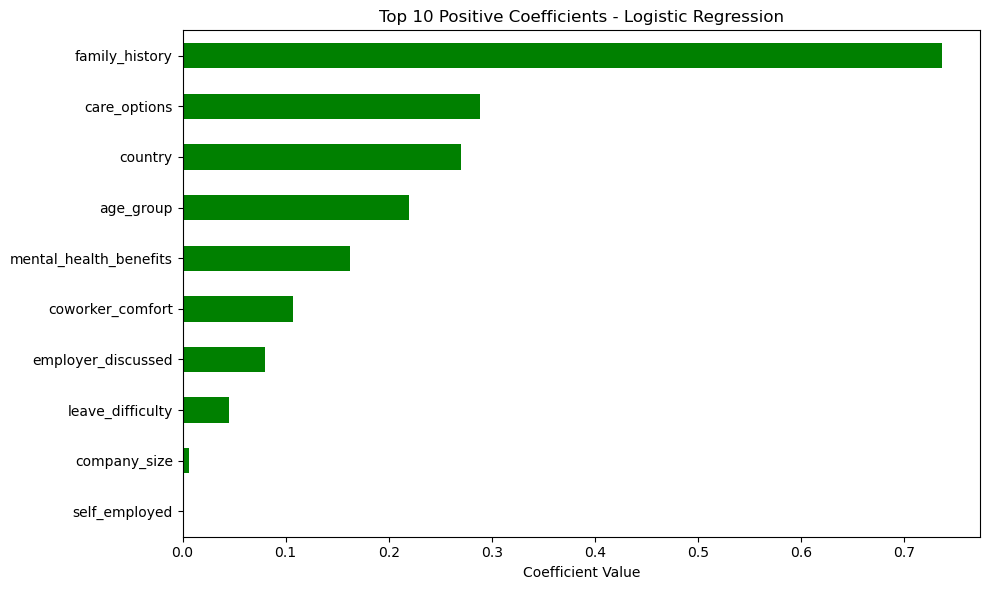

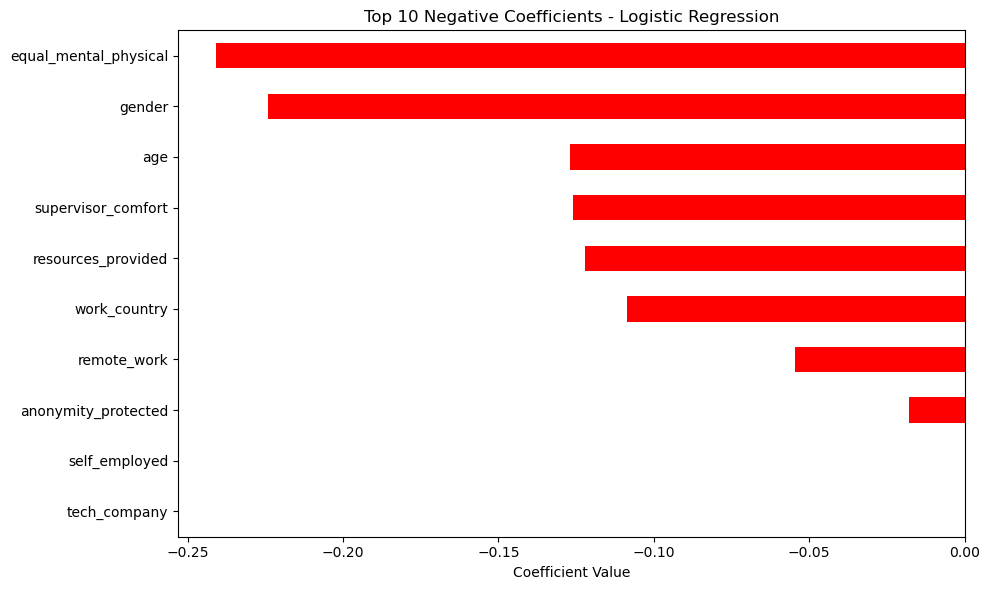

In [86]:
import matplotlib.pyplot as plt

# Extracting coefficients from trained logistic regression
logreg_coefficients = pd.Series(logreg.coef_[0], index=X.columns)

# Top 10 positive predictors (increase likelihood of seeking treatment)
top_positive = logreg_coefficients.nlargest(10)
print("Top 10 Positive Coefficients (Strong predictors of seeking treatment):\n")
print(top_positive, "\n")

# Top 10 negative predictors (reduce likelihood of seeking treatment)
top_negative = logreg_coefficients.nsmallest(10)
print("Top 10 Negative Coefficients (Strong predictors of NOT seeking treatment):\n")
print(top_negative, "\n")

# Plotting positive coefficients
plt.figure(figsize=(10, 6))
top_positive.plot(kind='barh', color='green')
plt.title("Top 10 Positive Coefficients - Logistic Regression")
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.show()

# Plotting negative coefficients
plt.figure(figsize=(10, 6))
top_negative.plot(kind='barh', color='red')
plt.title("Top 10 Negative Coefficients - Logistic Regression")
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


**5-Fold Cross-Validation, AUC, and Confusion Matrices**

Logistic Regression 5-Fold CV Accuracy: [0.68558952 0.68122271 0.6754386  0.69298246 0.6622807 ]
Mean CV Accuracy: 0.6795027962920402
Logistic Regression AUC: 0.7220385674931128


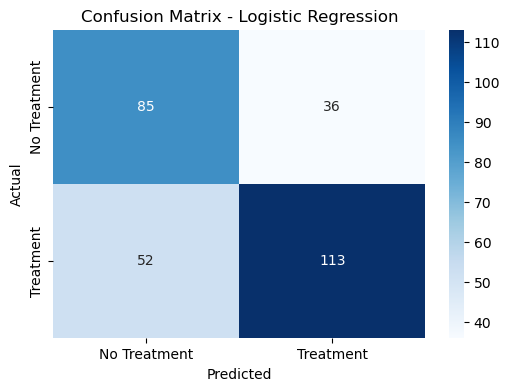

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.70      0.66       121
           1       0.76      0.68      0.72       165

    accuracy                           0.69       286
   macro avg       0.69      0.69      0.69       286
weighted avg       0.70      0.69      0.69       286



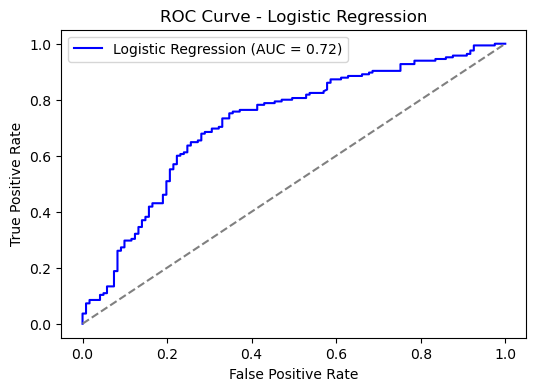

In [91]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 5-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logreg_cv_scores = cross_val_score(logreg, X_train_scaled, y_train, cv=cv, scoring='accuracy')
print("Logistic Regression 5-Fold CV Accuracy:", logreg_cv_scores)
print("Mean CV Accuracy:", logreg_cv_scores.mean())

# Predictions and AUC
y_pred_log = logreg.predict(X_test_scaled)
y_prob_log = logreg.predict_proba(X_test_scaled)[:,1]
auc_log = roc_auc_score(y_test, y_prob_log)
print("Logistic Regression AUC:", auc_log)

# Confusion Matrix
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6,4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', xticklabels=['No Treatment', 'Treatment'], yticklabels=['No Treatment', 'Treatment'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Classification Report:\n", classification_report(y_test, y_pred_log))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_log)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', label=f'Logistic Regression (AUC = {auc_log:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()
